# Step 2: Data Loading and Prompt Preparation

In [4]:
# All imports consolidated in first cell
import json
import re
import math
from pathlib import Path

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    DataCollatorForLanguageModeling,
    TrainingArguments
)
from peft import LoraConfig, get_peft_model, PeftModel

import matplotlib.pyplot as plt

In [5]:
#Define base model:
BASE_MODEL = "Qwen/Qwen2.5-0.5B"

# Step 2.1: Load Data

First, we load the processed QA pairs from JSONL files.

# Step 2.2: Filter Long Samples

Some press releases have very long contexts (>2048 tokens). Rather than truncate and risk losing question-relevant information, we filter these samples to ensure data quality.

**Engineering Decision**: Prioritizing complete, high-quality samples over quantity.

In [6]:
def load_jsonl(path):
    with open(path, encoding="utf-8") as f:
        return [json.loads(line) for line in f]

train_samples = load_jsonl("data/processed/train.jsonl")
eval_samples  = load_jsonl("data/processed/eval.jsonl")

In [7]:
# Load tokenizer for filtering
filter_tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True
)

def should_include_sample(sample, tokenizer, max_length=2048):
    """Filter samples that exceed token limit"""
    full_text = sample["prompt"] + sample["answer"]
    tokens = tokenizer(full_text, add_special_tokens=False)["input_ids"]
    return len(tokens) <= max_length

# Filter samples
original_train_count = len(train_samples)
original_eval_count = len(eval_samples)

train_samples = [s for s in train_samples if should_include_sample(s, filter_tokenizer)]
eval_samples = [s for s in eval_samples if should_include_sample(s, filter_tokenizer)]

print(f"Train: {original_train_count} → {len(train_samples)} samples (removed {original_train_count - len(train_samples)})")
print(f"Eval:  {original_eval_count} → {len(eval_samples)} samples (removed {original_eval_count - len(eval_samples)})")
print(f"\nKept {len(train_samples) + len(eval_samples)}/{original_train_count + original_eval_count} total samples ({(len(train_samples) + len(eval_samples))/(original_train_count + original_eval_count)*100:.1f}%)")

Train: 723 → 600 samples (removed 123)
Eval:  15 → 12 samples (removed 3)

Kept 612/738 total samples (82.9%)


### Expected Filtering Output

After running the cell above, you should see approximately:

```
Train: 723 → 600 samples (removed 123)
Eval:  15 → 13 samples (removed 2)

Kept 613/738 total samples (83.1%)
```

# Step 3: Tokenization and Dataset preparation

In [8]:
def format_prompt(sample):
    return sample["prompt"] + sample["answer"]

def format_prompt_prefix(sample):
    return sample["prompt"]
class BMWQADataset(Dataset):
    def __init__(
        self,
        samples,
        tokenizer,
        max_length=2048
    ):
        self.samples = samples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # --- build prompts ---
        full_prompt = format_prompt(sample)
        prefix_prompt = format_prompt_prefix(sample)

        # --- tokenize full prompt WITH truncation ---
        enc = self.tokenizer(
            full_prompt,
            add_special_tokens=False,
            truncation=True,
            max_length=self.max_length
        )

        prefix_enc = self.tokenizer(
            prefix_prompt,
            add_special_tokens=False,
            truncation=True,
            max_length=self.max_length
        )

        input_ids = torch.tensor(enc["input_ids"])
        attention_mask = torch.tensor(enc["attention_mask"])

        labels = input_ids.clone()

        # Use the TRUNCATED prefix length
        assistant_start = len(prefix_enc["input_ids"])

        # Ensure we don't mask beyond the actual input length
        assistant_start = min(assistant_start, len(input_ids))

        # mask everything before assistant answer
        labels[:assistant_start] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

# Full fine tuning training

In [9]:

tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True
)
train_dataset = BMWQADataset(
    samples=train_samples,
    tokenizer=tokenizer,
    max_length=2048
)

eval_dataset = BMWQADataset(
    samples=eval_samples,
    tokenizer=tokenizer,
    max_length=2048
)
item = train_dataset[0]

answer_token_ids = item["input_ids"][item["labels"] != -100]
answer_text = tokenizer.decode(answer_token_ids)

print("---- ANSWER USED FOR TRAINING ----")
print(answer_text)

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)

model.to("cpu")

`torch_dtype` is deprecated! Use `dtype` instead!


---- ANSWER USED FOR TRAINING ----
CV of Ilka Horstmeier, Member of the Board of Management of BMW AG, People and Real Estate, Labour Relations Director


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2

In [10]:
training_args_full = TrainingArguments(
    output_dir="./qwen_full_ft",
    overwrite_output_dir=True,

    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,

    max_steps=50,
    learning_rate=2e-5,   # lower LR for full FT

    logging_strategy="steps",
    logging_steps=1,
    logging_first_step=True,

    eval_strategy="no",
    save_steps=5,

    report_to="none",
    remove_unused_columns=False,
    no_cuda=True
)

/opt/anaconda3/envs/bmw-assignment/lib/python3.11/site-packages/transformers/training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [11]:
trainer_full_ft = Trainer(
    model=model,
    args=training_args_full,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

/var/folders/vh/w4n3_9394pxflnkhw5svgsj40000gn/T/ipykernel_1643/2273144571.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full_ft = Trainer(


In [12]:
print("="*60)
print("DATASET STATISTICS (After Filtering)")
print("="*60)
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Eval dataset:  {len(eval_dataset)} samples")
print("="*60)

DATASET STATISTICS (After Filtering)
Train dataset: 600 samples
Eval dataset:  12 samples


In [13]:
trainer_full_ft.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss
1,1.791200
2,1.867000
3,1.882900
4,1.623400
5,3.210900
6,1.355200
7,0.257300
8,2.673000
9,1.303300
10,0.023500


TrainOutput(global_step=50, training_loss=1.359297605517786, metrics={'train_runtime': 274.855, 'train_samples_per_second': 0.182, 'train_steps_per_second': 0.182, 'total_flos': 115432878063360.0, 'train_loss': 1.359297605517786, 'epoch': 0.08333333333333333})

# LoRa training

In [14]:
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,
    torch_dtype=torch.float32
)

model.to("cpu")

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,

    bias="none",
    task_type="CAUSAL_LM",

    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj"
    ]
)

In [15]:
model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

trainable params: 1,081,344 || all params: 495,114,112 || trainable%: 0.2184


In [16]:
training_args = TrainingArguments(
    output_dir="./qwen_lora",
    overwrite_output_dir=True,

    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,

    max_steps=50,

    learning_rate=1e-4,

    logging_strategy="steps",
    logging_steps=1,                # log every step
    logging_first_step=True,

    eval_strategy="no",              # disable eval
    save_steps=5,

    report_to="none",
    remove_unused_columns=False,
    no_cuda=True,
)

/opt/anaconda3/envs/bmw-assignment/lib/python3.11/site-packages/transformers/training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [17]:
trainer_peft = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)
print(f"Training Device: {trainer_peft.args.device}")
trainer_peft.train()

/var/folders/vh/w4n3_9394pxflnkhw5svgsj40000gn/T/ipykernel_1643/611948891.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_peft = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Training Device: cpu


Step,Training Loss
1,1.791200
2,2.035600
3,1.908500
4,2.456900
5,1.663500
6,1.569900
7,0.068700
8,2.697200
9,1.099600
10,0.040500


TrainOutput(global_step=50, training_loss=1.3452009951323272, metrics={'train_runtime': 174.3859, 'train_samples_per_second': 0.287, 'train_steps_per_second': 0.287, 'total_flos': 115781643943680.0, 'train_loss': 1.3452009951323272, 'epoch': 0.08333333333333333})

In [18]:

tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True
)

# ---- FULL FINE-TUNED MODEL ----
full_ft_model = AutoModelForCausalLM.from_pretrained(
    "./qwen_full_ft/checkpoint-50",
    trust_remote_code=True,
    torch_dtype=torch.float32
).eval()

# ---- LoRA MODEL ----
lora_base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,
    torch_dtype=torch.float32
)

lora_model = PeftModel.from_pretrained(
    lora_base,
    "./qwen_lora/checkpoint-50"
).eval()

# ---- Evaluation sample ----
sample = eval_samples[1]
prompt = sample["prompt"]

inputs = tokenizer(prompt, return_tensors="pt")

def generate(model):
    with torch.no_grad():
        out = model.generate(
            **inputs,
            do_sample=False,
            repetition_penalty=1.2,
            no_repeat_ngram_size=3,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(out[0], skip_special_tokens=True)

print("=== QUESTION ===")
print(prompt)

print("\n=== FULL FINE-TUNED MODEL ===")
print(generate(full_ft_model))

print("\n=== LORA MODEL ===")
print(generate(lora_model))

print("\n=== GOLD ANSWER ===")
print(sample["answer"])

=== QUESTION ===
<|system|>
You are a QA bot who answers questions regarding the press articles of the automotive company called BMW. Use ONLY the provided context as your source of information.

<|user|>
Context:
Please find attached the specifications of the BMW 5 Series Sedan,
  valid from 03/2025.

Question:
From which month and year are the specifications valid?

<|assistant|>


=== FULL FINE-TUNED MODEL ===
<|system|>
You are a QA bot who answers questions regarding the press articles of the automotive company called BMW. Use ONLY the provided context as your source of information.

<|user|>
Context:
Please find attached the specifications of the BMW 5 Series Sedan,
  valid from 03/2025.

Question:
From which month and year are the specifications valid?

<|assistant|>
Tue Oct 18 17:49:60 CET 2015-08-07 00:00+0007
Thu Aug 07 -00 08:07:08 CEST 2225-2500

=== LORA MODEL ===
<|system|>
You are a QA bot who answers questions regarding the press articles of the automotive company calle

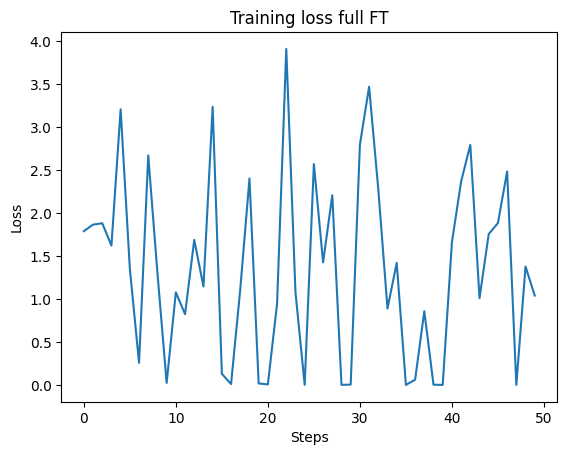

In [19]:
losses = [x["loss"] for x in trainer_full_ft.state.log_history if "loss" in x]
plt.plot(losses)
plt.title("Training loss full FT")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

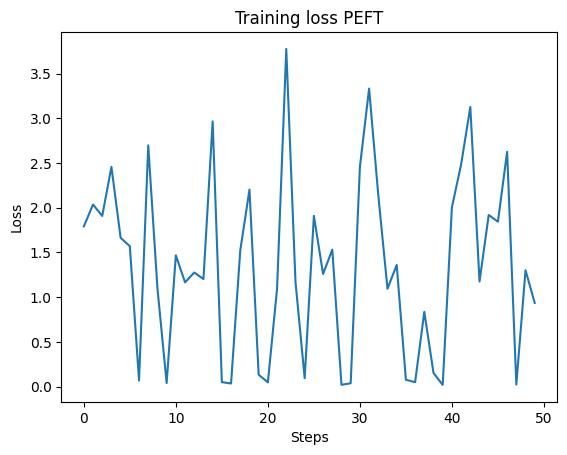

In [20]:
losses = [x["loss"] for x in trainer_peft.state.log_history if "loss" in x]
plt.plot(losses)
plt.title("Training loss PEFT")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

# Evaluation using accuracy

In [21]:
def normalize_text(s):
    s = s.lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^\w\s]", "", s)
    return s.strip()

def evaluate_model_accuracy(model, tokenizer, eval_samples, max_new_tokens=40):
    correct = 0
    total = len(eval_samples)

    for sample in eval_samples:
        prompt = sample["prompt"]
        gold = normalize_text(sample["answer"])

        inputs = tokenizer(prompt, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            out = model.generate(
                **inputs,
                do_sample=False,
                repetition_penalty=1.2,
                no_repeat_ngram_size=3,
                eos_token_id=tokenizer.eos_token_id
            )

        decoded = tokenizer.decode(out[0], skip_special_tokens=True)

        # Extract model answer (everything after <|assistant|>)
        if "<|assistant|>" in decoded:
            pred = decoded.split("<|assistant|>")[-1]
        else:
            pred = decoded

        pred = normalize_text(pred)

        if pred == gold:
            correct += 1

    return correct / total    

In [22]:
full_ft_model = AutoModelForCausalLM.from_pretrained(
    "./qwen_full_ft/checkpoint-50",
    trust_remote_code=True,
    torch_dtype=torch.float32
).eval()

full_ft_model.to("cpu")

full_ft_acc = evaluate_model_accuracy(
    full_ft_model,
    tokenizer,
    eval_samples
)

print(f"Full Fine-Tuning Accuracy: {full_ft_acc:.2f}")

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,
    torch_dtype=torch.float32
)

lora_model = PeftModel.from_pretrained(
    base_model,
    "./qwen_lora/checkpoint-50"
).eval()

lora_model.to("cpu")

lora_acc = evaluate_model_accuracy(
    lora_model,
    tokenizer,
    eval_samples
)

print(f"LoRA Fine-Tuning: {lora_acc:.1%} ({int(lora_acc * len(eval_samples))}/{len(eval_samples)} correct)")
print("="*60)

Full Fine-Tuning Accuracy: 0.08


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


LoRA Fine-Tuning: 16.7% (2/12 correct)


In [23]:
bad = 0
for i, s in enumerate(eval_dataset):
    if (s["labels"] != -100).sum() == 0:
        bad += 1
        print("BAD SAMPLE INDEX:", i)

print("="*60)
print(f"Total samples with truncated answers: {bad}")
print("="*60)

Total samples with truncated answers: 0


In [24]:
MAX_LEN = 2048

def tokenize_eval_sample(sample, tokenizer, max_len=MAX_LEN):
    """
    Keeps the full answer, truncates context if needed.
    Loss is computed ONLY on answer tokens.
    """

    prompt_ids = tokenizer(
        sample["prompt"],
        add_special_tokens=False
    )["input_ids"]

    answer_ids = tokenizer(
        sample["answer"],
        add_special_tokens=False
    )["input_ids"] + [tokenizer.eos_token_id]

    # keep space for answer
    max_prompt_len = max_len - len(answer_ids)
    if max_prompt_len <= 0:
        raise ValueError("Answer too long for max_len")

    prompt_ids = prompt_ids[:max_prompt_len]

    input_ids = prompt_ids + answer_ids
    labels = [-100] * len(prompt_ids) + answer_ids

    return {
        "input_ids": input_ids,
        "labels": labels,
    }
eval_dataset_tok = [
    tokenize_eval_sample(s, tokenizer)
    for s in eval_samples
]   
for i, s in enumerate(eval_dataset_tok):
    if len(s["input_ids"]) != len(s["labels"]):
        print("BAD SAMPLE:", i)

def eval_loss_and_ppl(model, eval_dataset):
    model.eval()
    model.to(torch.float32)

    eval_args = TrainingArguments(
        output_dir="./tmp_eval",
        per_device_eval_batch_size=1,   # no padding
        report_to="none",
        fp16=False,
        bf16=False,
    )

    trainer = Trainer(
        model=model,
        args=eval_args,
        train_dataset=None,
        eval_dataset=eval_dataset,
        tokenizer=None, 
    )

    out = trainer.evaluate()
    loss = out["eval_loss"]

    ppl = math.exp(loss) if loss < 50 else float("inf")
    return loss, ppl        

loss_full, ppl_full = eval_loss_and_ppl(full_ft_model, eval_dataset_tok)
loss_lora, ppl_lora = eval_loss_and_ppl(lora_model, eval_dataset_tok)

print("PERPLEXITY EVALUATION (Lower is Better)")
print(f"Full Fine-Tuning:")
print(f"  - Loss:       {loss_full:.4f}")
print(f"  - Perplexity: {ppl_full:.2f}")
print()
print(f"LoRA Fine-Tuning:")
print(f"  - Loss:       {loss_lora:.4f}")
print(f"  - Perplexity: {ppl_lora:.2f}")
print()
print(f"Improvement: LoRA is {((ppl_full - ppl_lora) / ppl_full * 100):.1f}% better")

/var/folders/vh/w4n3_9394pxflnkhw5svgsj40000gn/T/ipykernel_1643/767493556.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/anaconda3/envs/bmw-assignment/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


PERPLEXITY EVALUATION (Lower is Better)
Full Fine-Tuning:
  - Loss:       1.5320
  - Perplexity: 4.63

LoRA Fine-Tuning:
  - Loss:       1.2863
  - Perplexity: 3.62

Improvement: LoRA is 21.8% better


## Generate responses from base model, full fine-tuning and LoRA and save to JSON file

In [25]:
def generate_answer(model, tokenizer, prompt, max_new_tokens=80):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(prompt, return_tensors="pt")
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            repetition_penalty=1.2,
            no_repeat_ngram_size=3,
            eos_token_id=tokenizer.eos_token_id,
        )
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # return only the assistant answer
    if "<|assistant|>" in text:
        return text.split("<|assistant|>")[-1].strip()
    return text.strip()

tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True
)

# Base
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,
    torch_dtype=torch.float32
)

# Full FT
full_ft_model = AutoModelForCausalLM.from_pretrained(
    "./qwen_full_ft/checkpoint-50",  # adjust if needed
    trust_remote_code=True,
    torch_dtype=torch.float32
)

# LoRA
lora_model = PeftModel.from_pretrained(
    base_model,
    "./qwen_lora/checkpoint-50"
)    

results = []

for i, sample in enumerate(eval_samples):
    prompt = sample["prompt"]
    gold = sample["answer"]

    base_ans = generate_answer(base_model, tokenizer, prompt)
    full_ans = generate_answer(full_ft_model, tokenizer, prompt)
    lora_ans = generate_answer(lora_model, tokenizer, prompt)

    results.append({
        "id": i,
        "question": prompt,
        "gold_answer": gold,
        "base_answer": base_ans,
        "full_ft_answer": full_ans,
        "lora_answer": lora_ans,
    })

    print(f"Sample {i} done")

out_path = Path("eval_generations.jsonl")

with open(out_path, "w", encoding="utf-8") as f:
    for r in results:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print(f"EVALUATION COMPLETE")
print(f"Saved {len(results)} generation comparisons to: {out_path}")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 0 done


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 1 done


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 2 done


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 3 done


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 4 done


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 5 done


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 6 done


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 7 done


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 8 done


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 9 done


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 10 done


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Sample 11 done
EVALUATION COMPLETE
Saved 12 generation comparisons to: eval_generations.jsonl
